In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv('nasdaq/XeroxHoldingsCorp.csv', index_col = 'Date', parse_dates=True)

In [3]:
X = df.drop(columns='Volume')
y = df.iloc[:, 4:5]

In [4]:
cut_line = len(y)-round(len(y)/10)

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()
X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)
# Train Data
X_train = X_ss[:cut_line, :]
X_test = X_ss[cut_line:, :]
# Test Data 
""" ( 굳이 없어도 된다. 하지만 얼마나 예측데이터와 실제 데이터의 정확도를 확인하기 위해 from sklearn.metrics import accuracy_score 를 통해 정확한 값으로 확인할 수 있다. ) """ 
y_train = y_mm[:cut_line, :]
y_test = y_mm[cut_line:, :]
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)


Training Shape (9494, 5) (9494, 1)
Testing Shape (1055, 5) (1055, 1)


In [6]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape torch.Size([9494, 1, 5]) torch.Size([9494, 1])
Testing Shape torch.Size([1055, 1, 5]) torch.Size([1055, 1])


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device

In [8]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes 
        self.num_layers = num_layers #number of layers 
        self.input_size = input_size #input size 
        self.hidden_size = hidden_size #hidden state 
        self.seq_length = seq_length #sequence length 
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm 
        self.fc_1 = nn.Linear(hidden_size, 128) #fully connected 1 
        self.fc = nn.Linear(128, num_classes) #fully connected last layer 
        self.relu = nn.ReLU() 

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state 
        # Propagate input through LSTM 

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state 
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next 
        out = self.relu(hn) 
        out = self.fc_1(out) #first Dense 
        out = self.relu(out) #relu 
        out = self.fc(out) #Final Output 

        return out

In [9]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.0001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer


In [10]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass 
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0 
    # obtain the loss function 
    loss = loss_function(outputs, y_train_tensors.to(device)) 
    loss.backward() #calculates the loss of the loss function 
    optimizer.step() #improve from loss, i.e backprop 
    if epoch % 100 == 0: 
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05063
Epoch: 100, loss: 0.01943
Epoch: 200, loss: 0.01465
Epoch: 300, loss: 0.00931
Epoch: 400, loss: 0.00538
Epoch: 500, loss: 0.00313
Epoch: 600, loss: 0.00210
Epoch: 700, loss: 0.00153
Epoch: 800, loss: 0.00114
Epoch: 900, loss: 0.00085
Epoch: 1000, loss: 0.00066
Epoch: 1100, loss: 0.00053
Epoch: 1200, loss: 0.00043
Epoch: 1300, loss: 0.00036
Epoch: 1400, loss: 0.00031
Epoch: 1500, loss: 0.00027
Epoch: 1600, loss: 0.00023
Epoch: 1700, loss: 0.00020
Epoch: 1800, loss: 0.00017
Epoch: 1900, loss: 0.00015
Epoch: 2000, loss: 0.00013
Epoch: 2100, loss: 0.00011
Epoch: 2200, loss: 0.00010
Epoch: 2300, loss: 0.00009
Epoch: 2400, loss: 0.00008
Epoch: 2500, loss: 0.00007
Epoch: 2600, loss: 0.00006
Epoch: 2700, loss: 0.00006
Epoch: 2800, loss: 0.00006
Epoch: 2900, loss: 0.00005
Epoch: 3000, loss: 0.00005
Epoch: 3100, loss: 0.00005
Epoch: 3200, loss: 0.00005
Epoch: 3300, loss: 0.00005
Epoch: 3400, loss: 0.00005
Epoch: 3500, loss: 0.00004
Epoch: 3600, loss: 0.00004
Epoch: 3700, 

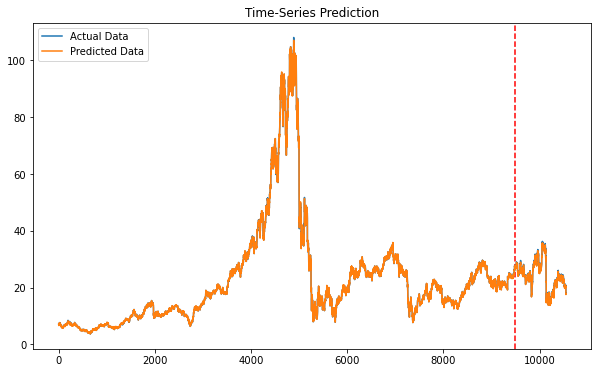

In [11]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 4:5])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=cut_line, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 